In [17]:
### PSV Data Preparation 

import pandas as pd
import os

# Create output folder
os.makedirs("cleaned", exist_ok=True)

# List of CSV files you mentioned
files = {
    "transfermarket": "Transfermarket.csv",
    "competitor_profiles": "combined_competitor_profiles.csv",
    "news_topics": "news_topics-sentiment-actions.csv",
    "socials_topics": "socials_topics-sentiment-actions.csv",
    "socials_overview": "socials-posts-overview.csv",
    "google_headlines": "Google_headlines.csv",
    "eventregistry_headlines": "Eventregistry_headlines.csv",
    "facebook_comments": "facebook-comments.csv",
    "facebook_competitors": "facebook-competitor-profiles.csv",
    "facebook_posts": "facebook-posts_overview.csv",
    "instagram_comments": "instagram-comments.csv",
    "instagram_posts": "instagram-posts_overview.csv",
    "tiktok_comments": "tiktok-comments.csv",
    "tiktok_posts": "tiktok-posts_overview.csv",
    "youtube_comments": "youtube-comments.csv"
}

In [23]:
def clean_csv(file_path, output_name):
    try:
        # Load with flexible options (inconsistent delimiters)
        df = pd.read_csv(file_path, sep=None, engine="python", on_bad_lines="skip")

        # Drop completely empty rows
        df.dropna(how="all", inplace=True)

        # Remove duplicate rows
        df.drop_duplicates(inplace=True)

        # Standardise column names
        df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

        if "competitor_profiles" in file_path.lower():
            if "club" in df.columns:
                df["club"] = df["club"].astype(str).str.upper().str.strip()

                # Replace known variants
                club_replacements = {
                    "FEYENOORD ROTTERDAM": "FEYENOORD",
                    "PSV EINDHOVEN": "PSV",
                    "AJAX AMSTERDAM": "AJAX",
                    "AZ ALKMAAR": "AZ",
                    "FC TWENTE ENSCHEDE": "FC TWENTE"
                }
                df["club"] = df["club"].replace(club_replacements)

                # Merge duplicates after normalization
                if "followers" in df.columns and "source" in df.columns:
                    df = df.groupby(["club", "source"], as_index=False)["followers"].sum()

        
        # Reset index
        df.reset_index(drop=True, inplace=True)

        # Save cleaned version
        out_path = os.path.join("cleaned", f"{output_name}_cleaned.csv")
        df.to_csv(out_path, index=False)

        # Report summary
        print(f"✅ {file_path} cleaned → {out_path}")
        print(f"   Rows: {len(df)}, Columns: {list(df.columns)}")
        print(f"   Missing values per column:\n{df.isna().sum()}\n")

        return df

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

In [25]:
# Process all files
datasets = {}
for name, path in files.items():
    datasets[name] = clean_csv(path, name)

✅ Transfermarket.csv cleaned → cleaned\transfermarket_cleaned.csv
   Rows: 17, Columns: ['name', 'position', 'number', 'age', 'market_value_eur', 'goals', 'assists', 'performance_score']
   Missing values per column:
name                 0
position             0
number               0
age                  0
market_value_eur     0
goals                0
assists              0
performance_score    0
dtype: int64

✅ combined_competitor_profiles.csv cleaned → cleaned\competitor_profiles_cleaned.csv
   Rows: 15, Columns: ['club', 'source', 'followers']
   Missing values per column:
club         0
source       0
followers    0
dtype: int64

✅ news_topics-sentiment-actions.csv cleaned → cleaned\news_topics_cleaned.csv
   Rows: 423, Columns: ['source', 'date', 'summary', 'topic', 'actionable_insight', 'neg_sentiment_(%)', 'pos_sentiment_(%)', 'neu_sentiment_(%)']
   Missing values per column:
source                0
date                  0
summary               0
topic                 0
action

In [26]:
### PSV Data Visualisation

import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean style
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Paths to cleaned data
path = "cleaned"

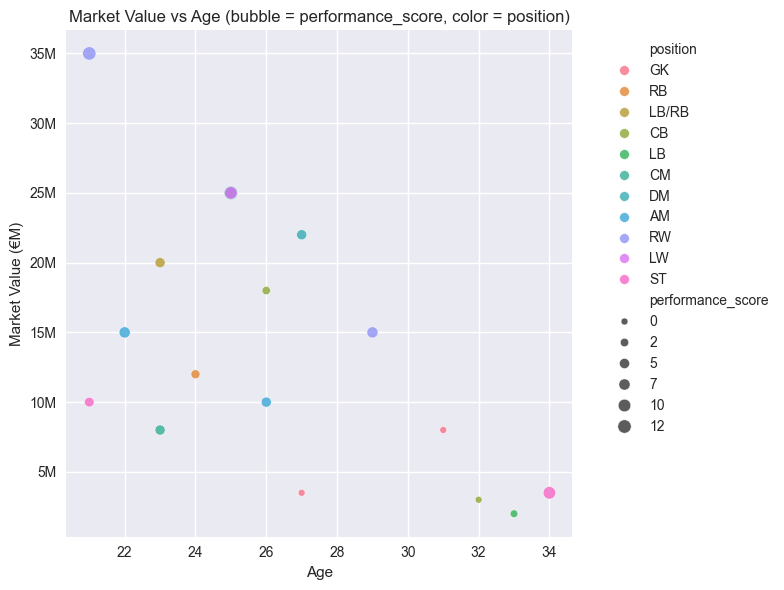

<Figure size 800x600 with 0 Axes>

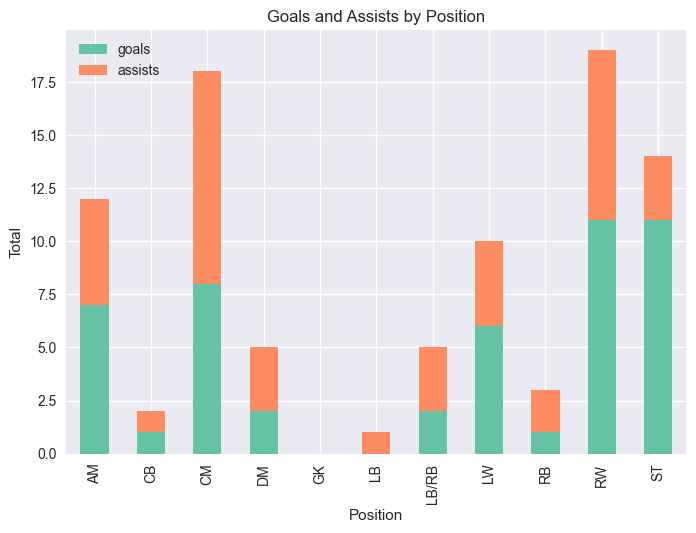

In [27]:
# -----------------------------
# 1. Transfermarket (Player Data)
# -----------------------------

import matplotlib.ticker as mtick
players = pd.read_csv(os.path.join(path, "transfermarket_cleaned.csv"))

# Market Value vs Age
plt.figure(figsize=(8,6))
sns.scatterplot(data=players, x="age", y="market_value_eur", size="performance_score", hue="position", alpha=0.8)
plt.title("Market Value vs Age (bubble = performance_score, color = position)")
plt.xlabel("Age")
plt.ylabel("Market Value (€M)")
# Format Y-axis as millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Goals & Assists by Position
plt.figure(figsize=(8,6))
players.groupby("position")[["goals","assists"]].sum().plot(kind="bar", stacked=True)
plt.title("Goals and Assists by Position")
plt.ylabel("Total")
plt.xlabel("Position")
plt.show()

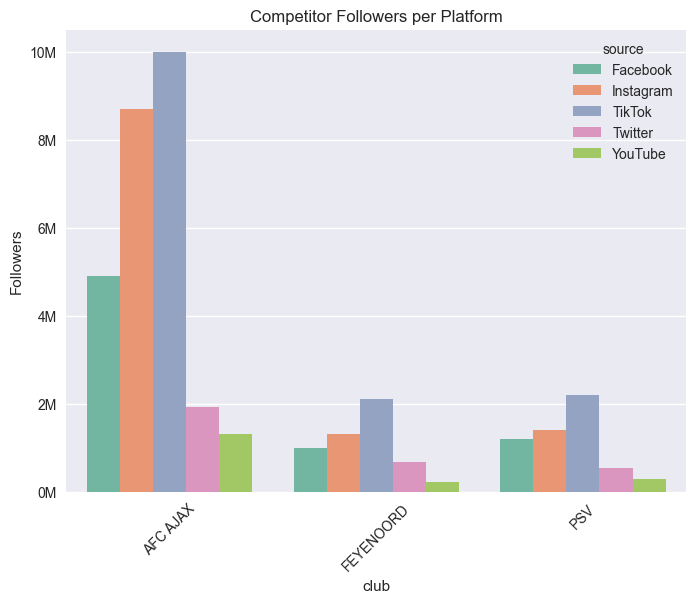

In [30]:
# -----------------------------
# 2. Competitor Social Profiles
# -----------------------------
competitors = pd.read_csv(os.path.join(path, "competitor_profiles_cleaned.csv"))
competitors["club"] = competitors["club"].str.upper()
plt.figure(figsize=(8,6))
sns.barplot(data=competitors, x="club", y="followers", hue="source", estimator=sum)
plt.title("Competitor Followers per Platform")
plt.ylabel("Followers")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
plt.xticks(rotation=45)
plt.show()

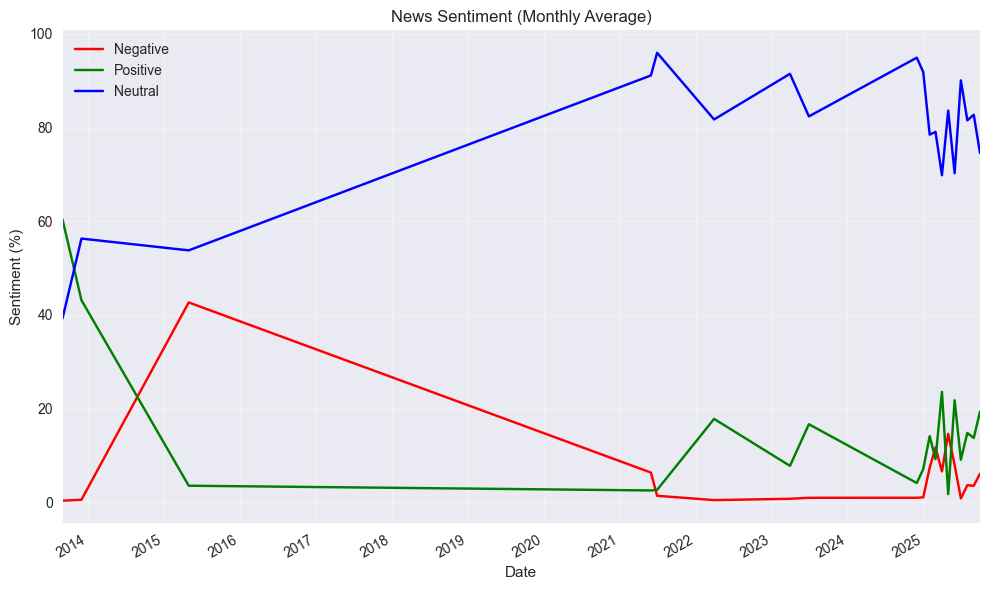

In [16]:
# -----------------------------
# 3. News Sentiment
# -----------------------------
import matplotlib.dates as mdates

news = pd.read_csv(os.path.join(path, "news_topics_cleaned.csv"))

# Convert date column
news["date"] = pd.to_datetime(news["date"], errors="coerce")
news = news.dropna(subset=["date"])  # Remove invalid dates
news.set_index("date", inplace=True)

# Calculate monthly averages
monthly_sentiment = (
    news.resample("M")[["neg_sentiment_(%)", "pos_sentiment_(%)", "neu_sentiment_(%)"]]
    .mean()
    .dropna(how="all")
)

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(monthly_sentiment.index, monthly_sentiment["neg_sentiment_(%)"], label="Negative", color="red")
plt.plot(monthly_sentiment.index, monthly_sentiment["pos_sentiment_(%)"], label="Positive", color="green")
plt.plot(monthly_sentiment.index, monthly_sentiment["neu_sentiment_(%)"], label="Neutral", color="blue")

plt.title("News Sentiment (Monthly Average)")
plt.ylabel("Sentiment (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)

# Limit x-axis to actual data range
plt.xlim(monthly_sentiment.index.min(), monthly_sentiment.index.max())

# Format x-axis ticks yearly, show only relevant years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


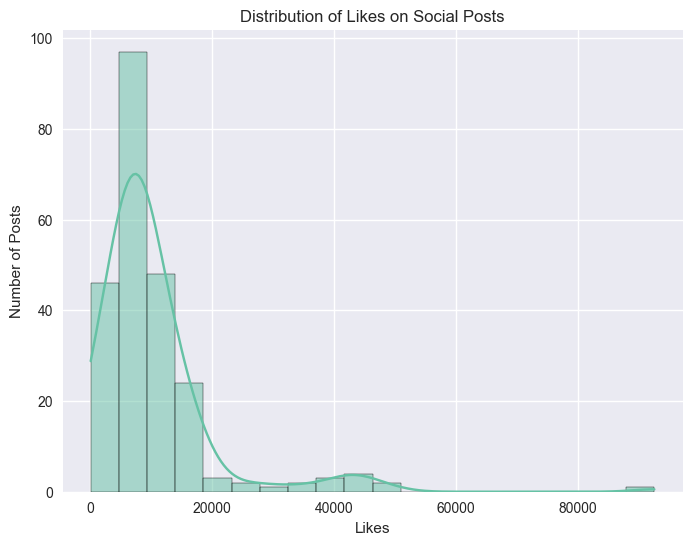

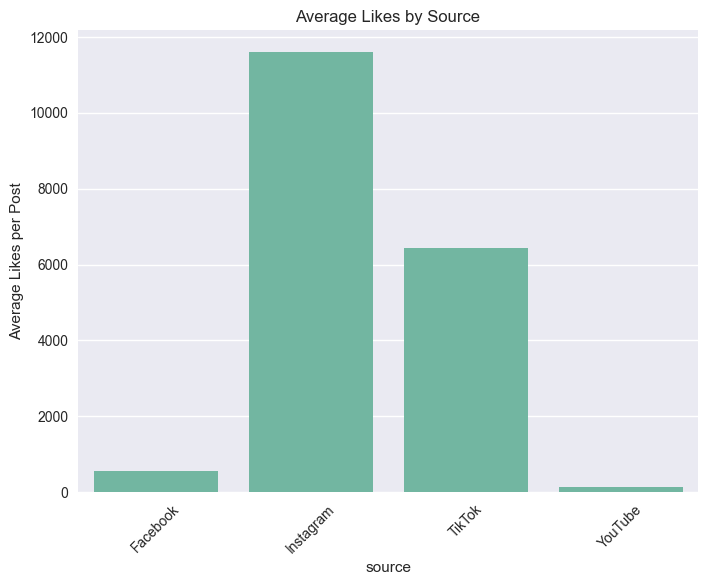

In [10]:
# -----------------------------
# 4. Social Media Engagement
# -----------------------------
socials = pd.read_csv(os.path.join(path, "socials_overview_cleaned.csv"))

# Fill missing counts with 0
socials[["num_comments","num_shares","likes","share_count"]] = socials[["num_comments","num_shares","likes","share_count"]].fillna(0)

plt.figure(figsize=(8,6))
sns.histplot(socials["likes"], bins=20, kde=True)
plt.title("Distribution of Likes on Social Posts")
plt.xlabel("Likes")
plt.ylabel("Number of Posts")
plt.show()

# Engagement by Source
plt.figure(figsize=(8,6))
avg_engagement = socials.groupby("source")["likes"].mean().reset_index()

sns.barplot(data=avg_engagement, x="source", y="likes")
plt.title("Average Likes by Source")
plt.ylabel("Average Likes per Post")
plt.xticks(rotation=45)
plt.show()

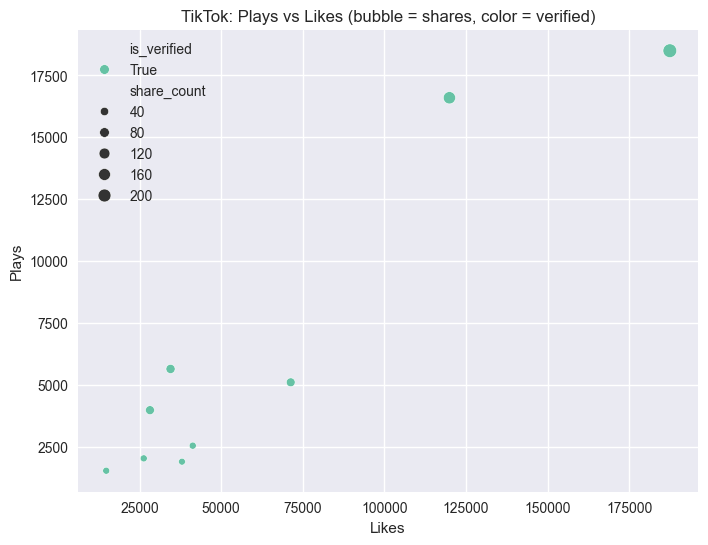

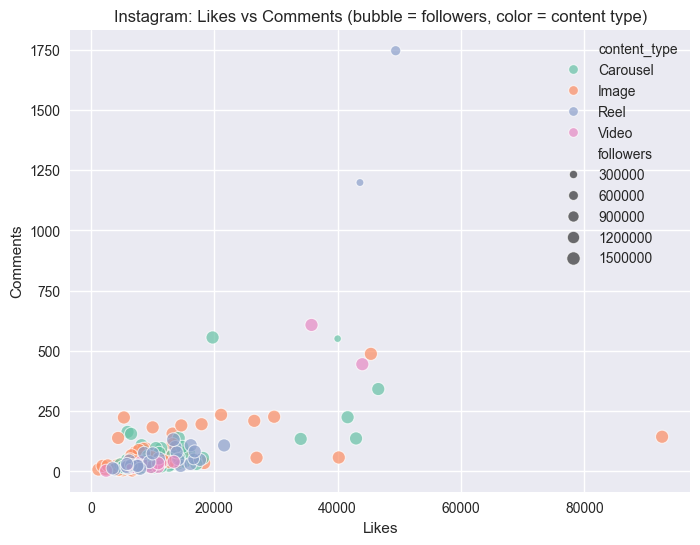

In [31]:
# -----------------------------
# 5. TikTok & Instagram Posts
# -----------------------------
tiktok = pd.read_csv(os.path.join(path, "tiktok_posts_cleaned.csv"))
insta = pd.read_csv(os.path.join(path, "instagram_posts_cleaned.csv"))

plt.figure(figsize=(8,6))
sns.scatterplot(data=tiktok, x="play_count", y="digg_count", size="share_count", hue="is_verified")
plt.title("TikTok: Plays vs Likes (bubble = shares, color = verified)")
plt.xlabel("Likes")
plt.ylabel("Plays")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=insta, x="likes", y="num_comments", size="followers", hue="content_type", alpha=0.7)
plt.title("Instagram: Likes vs Comments (bubble = followers, color = content type)")
plt.xlabel("Likes")
plt.ylabel("Comments")
plt.show()